# "FastHugs: Language Modelling with Tranformers and Fastai"
> Train a transformer language model from scratch or fine-tune a pretrained one using fastai and Huggingface.

- toc: false
- badges: true
- comments: true
- author: Morgan McGuire
- categories: [NLP, transformers, training technique, classification]

This aims to be an end-to-end description with code of how to train a transformer language model using fastai (v2) and HuggingFace, enjoy!

## TL;DR
Main interesting bits in this notebook:
- Provides full code to train a transformer (RoBERTa) using a Masked Language Model task
- Utilise's many of HuggingFace's tokenizer features within fastai
- Make predictions of masked tokens like this:

![]({{site.baseurl}}/my_icons/RoBERTa_pred.png "Testing our models predictions")

## Before we get started
- First off, huge thanks as always to both the Fastai and HuggingFace teams for giving so much back to the community by open-sourcing so much
- For an example of **text sequence classification** using HuggingFace and fastai, have a look at my previous notebook [**here**](https://github.com/morganmcg1/fasthugs/blob/master/fasthugs_seq_classification.ipynb)

- This tutorial is heavily based on HuggingFace's ["How to train a new language model from scratch using Transformers and Tokenizers"](https://huggingface.co/blog/how-to-train)  tutorial, I highly recommend checking that out too. I try and highlight throughout where code has been used, borrowed or inspired by HuggingFace's code.


## MLM Tranform
I feel the most useful thing in this notebook is the `MLMTokensLabels` transform*. This carries out the Masked Language Model task that RoBERTa was originally trained on.

This will take tokens ids (tokens after the have been numericalized), select a subset and either mask a certain amount of them (for prediction) or replace them with other random token ids (for regularisation). This transform also creates our labels by copying the input token ids and masking the tokens that do **not** need to be predicted, so that no loss is calculated on them. 

Note the if you wish to train BERT or other transformer language models you will probably need to use a different task, e.g. BERT was trained on 2 tasks simultaneously, MLM and Next Sentence Prediction (NSP). Have a look at any blog posts or arxiv paper of the transformer of interest to find which task was used to pretrain it.

*This transform code is a re-write of the `mask_tokens` function used in HugginFace's tutorial, [code here](https://github.com/huggingface/transformers/blob/a21d4fa410dc3b4c62f93aa0e6bbe4b75a101ee9/examples/run_language_modeling.py#L66)


## Pretraining + Fine-Tuning:

As shown in ULMFit, MultiFiT, and elsewhere, you will get better results on your downstream task if you first fine-tune your pretrained model with the text of the same domain as your pretrained task. e.g. training an IMDB movie review classifier who's language model was trained on wikipedia text.

> twitter: https://twitter.com/ssgrn/status/1253498613558243328 


## Using a Custom Tokenizer?
This code has not been tested using a custom tokenizer. You may want to do so if your text is very specific to a certain domain. If so then you'll have to add a number of attributes to your tokenzier to be able to use the code here. I really recommend the [HuggingFace language model tutorial linked above](https://huggingface.co/blog/how-to-train) for an example of training your own tokenizer with your own dataset

In [1]:
#hide
%reload_ext autoreload
%autoreload 2

from fastai2.basics import *
from fastai2.text.all import *
from fastai2.callback.all import *

from transformers import AutoModelWithLMHead, AutoModel, AutoModelForPreTraining, AutoTokenizer, AutoConfig #AutoModelForSequenceClassification
from splitters import *

import json

## Data
We'll use the `IMDB_SAMPLE` here, pretending we are fine-tuning our transformer model before doing sentiment classification on IMDB. If you are pretraining a language model from scratch you'd aim to use a larger, more generic source like a wikipedia dataset. fastai have the full `WikiText103` (100 million tokens) dataset available for easy download here if you'd like to train an enligh language model from scratch:

`path = untar_data(URLs.WIKITEXT)`

In [2]:
#hide
path = untar_data(URLs.IMDB_SAMPLE)
model_path = Path('models')
df = pd.read_csv(path/'texts.csv')

## HuggingFace Auto Classes

HuggingFace have a numer of useful ["Auto" classes](https://huggingface.co/transformers/model_doc/auto.html) that enable you to create different models and tokenizers by changing just the model name.

- `AutoModelWithLMHead` will define our Language model for us. This can either be a pretrained model or a randomly initialised model
- `AutoTokenizer` will load our tokenizer and enable us grab our vocab
- `AutoConfig` will define the model architecture and settings, note that we use the pretrained config here for ease of use, but one can easily modify this config if needed
- `model_name` is the model architecture (and optionally model weights) you'd like to use.
    - Language Models tested so far with this notebook: `roberta-base`
    - You can find all of HuggingFace's models at [https://huggingface.co/models](https://huggingface.co/models), most, but not all of them are supported by `AutoModel`,`AutoConfig` and `AutoTokenizer`
    
We can now easily call whichever transformer we like as below:

In [3]:
model_name = 'roberta-base' 
lm_model_class = AutoModelWithLMHead 
config_dict = AutoConfig.from_pretrained(model_name)

## HuggingFace Tokenizer & Vocab
We use `AutoTokenizer` to generate our pretrained tokenizer. HuggingFace's `get_vocab` returns a `token : index` dict however Fastai expects `vocab` to be a list. Therefore we need to convert this dict to a list to be able to use it in fastai

In [4]:
#collapse
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer_vocab=tokenizer.get_vocab() 
tokenizer_vocab_ls = [k for k, v in sorted(tokenizer_vocab.items(), key=lambda item: item[1])]
print(f'Tokenizer "{tokenizer.__class__}" vocab length is : {len(tokenizer_vocab_ls)}')

Tokenizer "<class 'transformers.tokenization_roberta.RobertaTokenizer'>" vocab length is : 50265


#### Special Tokens
Its always good to know what special tokens your tokenizer takes, lets have a look:

In [5]:
tokenizer.special_tokens_map

{'bos_token': '<s>',
 'eos_token': '</s>',
 'unk_token': '<unk>',
 'sep_token': '</s>',
 'pad_token': '<pad>',
 'cls_token': '<s>',
 'mask_token': '<mask>'}

## FastHugs Tokenizer
This tokenizer wrapper is initialised with the pretrained HF tokenizer, you can also specify the max_seq_len if you want longer/shorter sequences. Given text it returns tokens and adds separator tokens depending on the model type being used.

In [6]:
# collapse
class FastHugsTokenizer():
    """ 
        transformer_tokenizer : takes the tokenizer that has been loaded from the tokenizer class
        model_name : model type set by the user
        max_seq_len : override default sequence length, typically 512 for bert-like models.
                           `transformer_tokenizer.max_len_single_sentence` and `transformer_tokenizer.max_len_sentences_pair` 
                           both account for the need to add additional special tokens, i.e. for RoBERTa-base 
                           max_len_single_sentence==510, leaving space for the 2 additional special tokens 
                           to be added for the model's default 512 positional embeddings
        pair : whether a single sentence (sequence) or pair of sentences are used

        Returns:
            - Tokenized text, up to the max sequence length set by the user or the tokenzier default
    """
    def __init__(self, transformer_tokenizer=None, model_name='roberta', max_seq_len=None, 
                 pretrained=True, pair=False, **kwargs): 
        self.model_name, self.tok, self.max_seq_len=model_name, transformer_tokenizer, max_seq_len
        if pretrained:
            if self.max_seq_len:
                if pair: assert self.max_seq_len<=self.tok.max_len_sentences_pair, 'WARNING: max_seq_len needs to be less than or equal to transformer_tokenizer.max_len_sentences_pair'
                else: assert self.max_seq_len<=self.tok.max_len_single_sentence, 'WARNING: max_seq_len needs to be less than or equal to transformer_tokenizer.max_len_single_sentence'
            else:
                if pair: self.max_seq_len=ifnone(max_seq_len, self.tok.max_len_sentences_pair) 
                else: self.max_seq_len=ifnone(max_seq_len, self.tok.max_len_single_sentence)

    def do_tokenize(self, o:str):
        """Returns tokenized text, adds prefix space if needed, limits the maximum sequence length"""
        if 'roberta' in model_name: tokens=self.tok.tokenize(o, add_prefix_space=True)[:self.max_seq_len]
        else: tokens = self.tok.tokenize(o)[:self.max_seq_len]
        return tokens
    
    def de_tokenize(self, o):
        """Return string from tokens"""
        text=self.tok.convert_tokens_to_string(o)
        return text
        
    def __call__(self, items): 
        for o in items: yield self.do_tokenize(o)

## The Fastai bit

### `fasthugstok` and our `tok_fn`
Lets incorporate the `tokenizer` from HuggingFace into fastai-v2's framework by specifying a function called `fasthugstok` that we can then pass on to `Tokenizer.from_df`. (Note `.from_df` is the only method I have tested)

#### Max Seqence Length
`max_seq_len` is the longest sequece our tokenizer will output. We can also the max sequence length for the tokenizer by changing `max_seq_len`. It uses the tokenizer's default, typically `512`. `1024` or even `2048` can also be used depending on your GPU memory. Note when using pretrained models you won't be able to use a `max_seq_len` larger than the default. 

In [7]:
max_seq_len = None  
sentence_pair=False

fasthugstok = partial(FastHugsTokenizer, transformer_tokenizer=tokenizer, model_name=model_name, 
                      max_seq_len=max_seq_len, sentence_pair=sentence_pair)

We create a `MLMTokenizer` class which inherits from fastai's `Tokenizer` in order to fully decode 

In [8]:
#collapse
class MLMTokenizer(Tokenizer):
    def __init__(self, tokenizer, rules=None, counter=None, lengths=None, mode=None, sep=' ', **kwargs): 
        super().__init__(tokenizer, rules, counter, lengths, mode, sep)
    def _detokenize1(self, o):return self.tokenizer.de_tokenize(o)
    def decodes(self, o): return TitledStr(str(self._detokenize1(o)))

Set up fastai's `Tokenizer.from_df`, we pass `rules=[fix_html]` to clean up some of HTML messiness in our text. If you do not want any rules then you sould pass `rules=[]` to override fastai's default text processing rules

In [9]:
#collapse
fastai_tokenizer = MLMTokenizer.from_df(text_cols='text', res_col_name='text', tok_func=fasthugstok, 
                                     rules=[fix_html], post_rules=[])
fastai_tokenizer.rules

[<function fastai2.text.core.fix_html(x)>]

### Add Special Tokens
BERT-like transformers require special tokens to be added to the sequence, depending on the task, so we need a transform for those too

In [10]:
class AddSpecialTokens(Transform):
    "Add special token_ids to the numericalized tokens for Sequence Classification"
    def __init__(self, tokenizer):
        self.tok=tokenizer
    def encodes(self, o):
        return(TensorText(self.tok.build_inputs_with_special_tokens(list(o))))

## Create MLM Dataset

In [11]:
#collapse
class MLMTokensLabels(Transform):
    '''
        MLM task
        - Select subset of input token ids, given by `mlm_probability`
        - Mask a subset of these, `mask_token_prob`
        - Replace half of the first subset with random tokens
        - This code most comes from the `mask_tokens` function here https://github.com/huggingface/transformers/blob/a21d4fa410dc3b4c62f93aa0e6bbe4b75a101ee9/examples/run_language_modeling.py#L66
        Returns: input ids and labels
    '''
    def __init__(self, tokenizer=None, mlm_probability=0.15, mask_token_prob=0.8):
        self.tok, self.mlm_probability, self.mask_token_prob=tokenizer, mlm_probability, mask_token_prob
    
    def _gen_probability_matrix(self, labels):
        # We sample a few tokens in each sequence for masked-LM training (with probability mlm_probability, defaults to 0.15 in Bert/RoBERTa)
        probability_matrix = torch.full(labels.shape, self.mlm_probability) 
        special_tokens_mask = self.tok.get_special_tokens_mask(labels.tolist(), already_has_special_tokens=True)
        probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
        if self.tok._pad_token is not None:
            padding_mask = labels.eq(self.tok.pad_token_id)
            probability_matrix.masked_fill_(padding_mask, value=0.0)
        return probability_matrix
    
    def _replace_with_mask(self, inputs, labels, masked_indices):
        # for `mask_token_prob`% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
        indices_replaced = torch.bernoulli(torch.full(labels.shape, self.mask_token_prob)).bool() & masked_indices
        inputs[indices_replaced] = self.tok.convert_tokens_to_ids(self.tok.mask_token)
        return inputs, indices_replaced
    
    def _replace_with_other(self, inputs, labels, masked_indices, indices_replaced):
        # 1-`mask_token_prob`)/210% of the time, we replace masked input tokens with random word
        indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
        random_words = torch.randint(len(self.tok), labels.shape, dtype=torch.long)
        inputs[indices_random] = random_words[indices_random]
        return inputs
    
    def encodes(self, inputs):
        if self.tok.mask_token is None:
            raise ValueError("This tokenizer does not have a mask token which is necessary for masked language modeling.")
        labels = inputs.clone()
        
        # Get probability of whether a token will be masked
        probability_matrix = self._gen_probability_matrix(labels)
        
        # Create random mask indices according to probability matrix
        masked_indices = torch.bernoulli(probability_matrix).bool()
        
        # Mask the labels for indices that are NOT masked, we only compute loss on masked tokens
        labels[~masked_indices] = -100  
        
        # Randomly replace with mask token
        inputs, indices_replaced = self._replace_with_mask(inputs, labels, masked_indices)
        
        # Randomly replace with mask token
        inputs = self._replace_with_other(inputs, labels, masked_indices, indices_replaced)
        # The rest of the time (10% of the time) we keep the masked input tokens unchanged
        return (inputs,labels)

In [12]:
# collapse
@Numericalize
def decodes(self,o):
    'Add the ability to parse masks for the loss function, set as `-100`'
    if isinstance(o, tuple): o=o[0]
    tmp_vocab=self.vocab.copy()
    tmp_vocab.append('<loss_mask>')
    o=[-1 if o_ == -100 else o_ for o_ in o]
    return L(tmp_vocab[o_] for o_ in o if tmp_vocab[o_] != PAD)

In [13]:
# collapse
@delegates(Datasets)
class Datasets(Datasets):
    "Doesn't create a tuple in __getitem__ as x is already a tuple"
    def __init__(self, items=None, tfms=None, tls=None, n_inp=None, dl_type=None, **kwargs):
        super().__init__(items=items, tfms=tfms, tls=tls, n_inp=n_inp, dl_type=dl_type, **kwargs)

    def __getitem__(self, it):
        # same as Datasets.__getitem__ but not wrapped in a tuple
        res = [tl[it] for tl in self.tls]
        return res[0] if is_indexer(it) else list(zip(*res))

Our dataset is now ready to be created, lets look at an some of our (x,y) that will be passed to the model. When `-100` is passed to our loss function (`nn.CrossEntropyLoss`) it will be ignored in the calculation. Our model will also ignore any padding tokens (usually defined as `1`) when passed to it.

In [14]:
#collapse-hide
splits = ColSplitter()(df)
tfms=[attrgetter("text"), fastai_tokenizer, Numericalize(vocab=tokenizer_vocab_ls), 
      AddSpecialTokens(tokenizer), MLMTokensLabels(tokenizer)]

dsets = Datasets(df, splits=splits, tfms=[tfms], dl_type=SortedDL)

dsets[0][0][:20], dsets[0][1][:20]

(tensor([    0,  1890,    12,  5225, 24320,    12,  8494, 18421, 50264,   328,
         14938,  1774,   630,    75,   190,   356,    69, 50264, 32819,   784]),
 tensor([ -100,  -100,  -100,  5225,  -100,  -100,  -100, 18421,  -100,  -100,
          -100,  -100,  -100,    75,  -100,  -100,  -100,  4505,  -100,   784]))

## Dataloader
### Padding
We need to make sure our padding is done correctly as some transformer models prefer padding on the left while others prefer it on the right. `tokenizer.padding_side` will tell us which side is correct. e.g., BERT, Roberta prefers padding to the right, so we set `pad_first=False`

In [15]:
#collapse
def pad_mlm_input(samples, pad_idx=1, pad_fields=[0,1], pad_first=False, max_seq_len=None, backwards=False):
    "Function that collect `samples` and adds padding, modified `max_len_l` in fastai's `pad_input`"
    pad_fields = L(pad_fields)
    #max_len_l = ifnone(max_seq_len, pad_fields.map(lambda f: max([len(s[f]) for s in samples])))
    max_len_l = pad_fields.map(lambda f: max_seq_len)
    if backwards: pad_first = not pad_first
    def _f(field_idx, x):
        if isinstance(x, tuple): x=(x[0]) ## Added this line too, removes tuple if present
        if field_idx not in pad_fields: return x
        idx = pad_fields.items.index(field_idx) #TODO: remove items if L.index is fixed
        sl = slice(-len(x), sys.maxsize) if pad_first else slice(0, len(x))
        pad =  x.new_zeros(max_len_l[idx]-x.shape[0])+pad_idx
        x1 = torch.cat([pad, x] if pad_first else [x, pad])
        if backwards: x1 = x1.flip(0)
        return retain_type(x1, x)
    return [tuple(map(lambda idxx: _f(*idxx), enumerate(s))) for s in samples]

def transformer_mlm_padding(tokenizer=None, max_seq_len=None, sentence_pair=False): 
    'Uses `pad_fields=[0,1]` to pad both input and label'
    if tokenizer.padding_side == 'right': pad_first=False
    else: pad_first=True
    max_seq_len = ifnone(max_seq_len, tokenizer.max_len) 
    return partial(pad_mlm_input, pad_fields=[0,1], pad_first=pad_first, 
                   pad_idx=tokenizer.pad_token_id, max_seq_len=max_seq_len)

In [16]:
#collapse
padding=transformer_mlm_padding(tokenizer)

bs=4
dls = dsets.dataloaders(bs=bs, before_batch=[padding])

#### Check our batch
We can see our special RoBERTa tokens (`'<s>'`, `'</s>'`), which translate to `0, 2` in its vocab, have been added to the start and end of each sequence in the batch. Your can look at these indices in `tokenizer.get_vocab()` to confirm this. We can also see that most of the tokens in our target (`text_`) are masked out as we only want to calculate the loss on the ~15% of the `text` tokens that have been masked.

In [17]:
#collapse
b=dls.one_batch()
b[0].size(), b[1].size()

(torch.Size([4, 512]), torch.Size([4, 512]))

In [18]:
#collapse
dls.show_batch()

## Model
Our model can be instantiated with either pretrained or random weights. We also need to be careful to pass the model the `attention_mask` so that the model ignores padding tokens when training. 

In [19]:
class LMModel(nn.Module):
    def __init__(self, lm_model_class=None, tokenizer=None, model_name=None, config_dict=None, pretrained=False):
        super().__init__()
        self.tok=tokenizer
        if pretrained: self.model = lm_model_class.from_pretrained(model_name)
        else: self.model = lm_model_class.from_config(config_dict)
        self.model = self.model.module if hasattr(self.model, "module") else self.model
        self.model.resize_token_embeddings(len(tokenizer))
            
    def forward(self, input_ids):
        attention_mask =  (input_ids!=self.tok.pad_token_id).type(input_ids.type())
        return self.model(input_ids, attention_mask=attention_mask)[0]    # only return the prediction_scores (and not hidden states and attention)

### Pretrained Language Model
Lets fine-tune our pretrained Language Model. We would typically do this before training the model on our specific text. Note that here we are not training the language model head before we train the full model, but we could do so if we created a splitter and passed it to our learner

To load the pretrained HuggingFace model just use `pretrained=True` when calling your model:

In [20]:
model = LMModel(lm_model_class=lm_model_class, tokenizer=tokenizer, model_name=model_name, 
                  config_dict=config_dict, pretrained=True)

## Training
From here we train our model as usual using fastai. Note that we use `Perplexity` as our metric as it is a good measure of how well a language model is training

In [21]:
#collapse
opt_func = partial(Adam, decouple_wd=True)

loss = CrossEntropyLossFlat()

learn = Learner(dls, model, opt_func=opt_func, #splitter=model_splitter, 
                loss_func=loss, metrics=[accuracy, Perplexity()]).to_fp16()

We check our learning rate finder

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.2089296132326126)

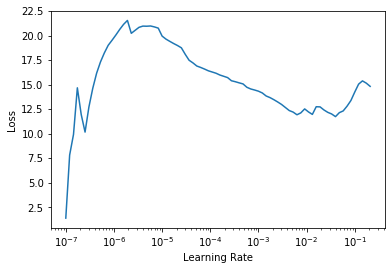

In [50]:
#collapse-hide
learn.lr_find(suggestions=True, stop_div=False)

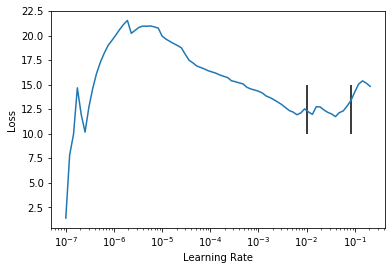

In [52]:
#hide
learn.recorder.plot_lr_find()
plt.vlines(0.01, 10, 15)
plt.vlines(0.083, 10, 15)

We do some training

In [53]:
#collapse-hide
learn.fit_one_cycle(10, lr_max=1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,13.052832,11.317341,0.052725,82235.375000,00:32
1,8.539399,5.935386,0.049121,378.185822,00:32
2,1.660586,0.785814,0.493350,2.194192,00:32
3,0.731211,0.768679,0.493125,2.156916,00:32
4,0.732979,0.772890,0.492373,2.166016,00:32
5,0.681202,0.695503,0.493711,2.004716,00:33
6,0.660206,0.681334,0.494063,1.976512,00:33
7,0.469388,0.641964,0.495615,1.900209,00:33
8,0.512519,0.612524,0.494834,1.845082,00:33
9,0.545736,0.625833,0.495205,1.869804,00:33


In [54]:
#hide
learn.save('roberta_lm_pretrained')

And we see how our loss progressed

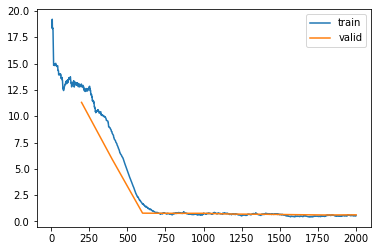

In [55]:
#hide
learn.recorder.plot_loss()

## Lets Look at the model's predictions
Manually checking how well our model makes predictions for masked tokens is a simple way to see how it is training

Here function `get_mask_pred` takes masked string given by the user and returns the `topk` predictions given by the model for that masked token. With it we can sanity check that our model has learned something useful!  

*Note that `get_mask_pred` is mostly code from `FillMaskPipeline` in HuggingFace's Transformers repo, full credit to them!

In [29]:
#collapse
def get_mask_pred(model, masked_text:str, topk:int=5):
    "Code lightly modified from `FillMaskPipeline` in the HuggingFace Transformers library"
    
    aa=fastai_tokenizer.encodes(masked_text)
    bb=Numericalize(vocab=tokenizer_vocab_ls)(aa)
    cc=AddSpecialTokens(tokenizer)(bb)
    
    outs=model(cc.unsqueeze(0).cuda())
    masked_index = (cc == tokenizer.mask_token_id).nonzero().item()
    logits = outs[0, masked_index, :]
    probs = logits.softmax(dim=0)
    values, predictions = probs.topk(topk)
    
    result=[]
    for i, vv in enumerate(zip(values.tolist(), predictions.tolist())):
        v, p =vv
        tokens = cc.numpy()
        if i == 0: result.append({"word":"Input text", "score": 0., "token": 0, "sequence": tokenizer.decode(tokens)}) 
        tokens[masked_index] = p
        tokens = tokens[np.where(tokens != tokenizer.pad_token_id)]
        w = tokenizer.decode(p)
        result.append({"word":w, "score": v, "token": p, "sequence": tokenizer.decode(tokens)}) 

    return pd.DataFrame(result)

Here we can input our own masked sentence and see how the model does. Note that even without fine-tuning the performance below will still be very strong as the pretrained RoBERTa model is very strong.

In [30]:
text2 = 'I was walking to <mask> when I came across a cat on the road'
pred2 = get_mask_pred(model1, text2);pred2.head()

,word,score,token,sequence
0,Input text,0.000000,0,<s> I was walking to<mask> when I came across a cat on the road</s>
1,school,0.791473,334,<s> I was walking to school when I came across a cat on the road</s>
2,church,0.068957,2352,<s> I was walking to church when I came across a cat on the road</s>
3,work,0.068007,173,<s> I was walking to work when I came across a cat on the road</s>
4,breakfast,0.007202,7080,<s> I was walking to breakfast when I came across a cat on the road</s>


**Not bad at all!** Now lets see how it does on a movie review, lets look at an example from our validation set. We mask the word `might` from the first sentence of the reivew, `... shows what might happen...` 

In [68]:
mask_indices=[7]
txts=df.text.values
masked_text = txts[800].split(' ')  # our validation split starts at index 800
masked_text[mask_indices[0]] = '<mask>'
masked_text = " ".join(masked_text)

pred1 = get_mask_pred(model1, masked_text);pred1.head()

,word,score,token,sequence
0,Input text,0.000000,0,"<s> This very funny British comedy shows what<mask> happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of ancient documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><b..."
1,would,0.809723,74,"<s> This very funny British comedy shows what would happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of ancient documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><b..."
2,might,0.131539,429,"<s> This very funny British comedy shows what might happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of ancient documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><b..."
3,could,0.042638,115,"<s> This very funny British comedy shows what could happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of ancient documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><b..."
4,will,0.009556,40,"<s> This very funny British comedy shows what will happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of ancient documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><br..."


Boom, pretty darn good! Lets try the same example, replacing `ancient` in `discovery of ancient documents ` 

In [69]:
mask_indices=[54]
txts=df.text.values
masked_text = txts[800].split(' ')  # our validation split starts at index 800
masked_text[mask_indices[0]] = '<mask>'
masked_text = " ".join(masked_text)

pred1 = get_mask_pred(model, masked_text);pred1.head()

,word,score,token,sequence
0,Input text,0.000000,0,"<s> This very funny British comedy shows what might happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of<mask> documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><br ..."
1,historical,0.585666,4566,"<s> This very funny British comedy shows what might happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of historical documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /..."
2,old,0.086817,793,"<s> This very funny British comedy shows what might happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of old documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><br />..."
3,obscure,0.040825,23732,"<s> This very funny British comedy shows what might happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of obscure documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><b..."
4,ancient,0.035504,8178,"<s> This very funny British comedy shows what might happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of ancient documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><b..."


Again, pretty solid predictions!

## Train a Language Model from Scratch!
We can follow the same procedure to train a language model from scratch by using `pretrained=False` when seeing up our model

In [47]:
#collapse
model = LMModel(lm_model_class=lm_model_class, tokenizer=tokenizer, model_name=model_name, 
                  config_dict=config_dict, pretrained=False)

opt_func = partial(Adam, decouple_wd=True)

loss = CrossEntropyLossFlat()

learn = Learner(dls, model, opt_func=opt_func, loss_func=loss, metrics=[accuracy, Perplexity()]).to_fp16()

## Training

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.7585775852203369)

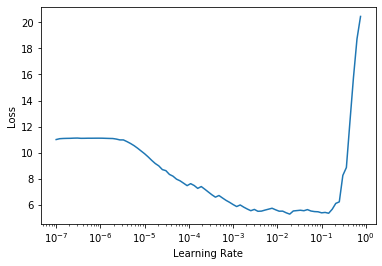

In [49]:
#hide
learn.lr_find(suggestions=True, stop_div=False)

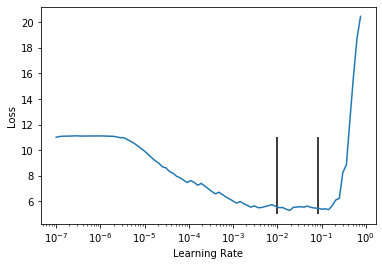

In [50]:
#hide
learn.recorder.plot_lr_find()
plt.vlines(0.01, 5, 11)
plt.vlines(0.083, 5, 11)

In [51]:
#hide
learn.fit_one_cycle(10, lr_max=1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.394903,2.887095,0.447363,17.941114,00:32
1,2.046408,2.402153,0.447598,11.046932,00:32
2,2.477659,2.258497,0.449160,9.568699,00:33
3,1.796320,2.221159,0.450840,9.218013,00:33
4,2.447208,2.173755,0.451035,8.791237,00:33
5,2.000578,2.153078,0.451045,8.611320,00:33
6,2.281767,2.142533,0.451709,8.520996,00:33
7,1.852895,2.122231,0.451953,8.349741,00:33
8,2.069045,2.148971,0.451729,8.576032,00:33
9,1.800070,2.126904,0.452148,8.388855,00:33


In [52]:
#hide
learn.save('roberta_lm_scratch')

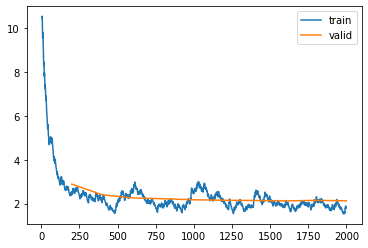

In [53]:
#hide
learn.recorder.plot_loss()

## Untrained 
Again, lets look at the predictions:

In [54]:
model2=learn.model

In [58]:
text2 = 'I was walking to <mask> when I cam across a cat on the road'
pred2 = get_mask_pred(model2, text2);pred2.head()

,word,score,token,sequence
0,Input text,0.000000,0,<s> I was walking to<mask> when I cam across a cat on the road</s>
1,the,0.037963,5,<s> I was walking to the when I cam across a cat on the road</s>
2,.,0.036504,4,<s> I was walking to. when I cam across a cat on the road</s>
3,",",0.033266,6,"<s> I was walking to, when I cam across a cat on the road</s>"
4,of,0.024381,9,<s> I was walking to of when I cam across a cat on the road</s>


Pretty bad 👎, and see how the unconfident it is in its predictions! This doesn't perform well because we have only used 800 movie reviews to train our model, we'll need a lot more text to get decent results!

Again, just for fun, lets see how it does on a movie review, lets look at an example from our validation set. We mask the word `might` from the first sentence of the reivew, `... shows what might happen...` 

In [60]:
mask_indices=[7]
txts=df.text.values
masked_text = txts[800].split(' ')  # our validation split starts at index 800
masked_text[mask_indices[0]] = '<mask>'
masked_text = " ".join(masked_text)

pred1 = get_mask_pred(model2, masked_text);pred1.head()

,word,score,token,sequence
0,Input text,0.000000,0,"<s> This very funny British comedy shows what<mask> happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of ancient documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><b..."
1,",",0.044226,6,"<s> This very funny British comedy shows what, happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of ancient documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><br />S..."
2,the,0.035027,5,"<s> This very funny British comedy shows what the happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of ancient documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><br ..."
3,.,0.028172,4,"<s> This very funny British comedy shows what. happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of ancient documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><br />S..."
4,and,0.025764,8,"<s> This very funny British comedy shows what and happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of ancient documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><br ..."


Ewww..

In [61]:
mask_indices=[54]
txts=df.text.values
masked_text = txts[800].split(' ')  # our validation split starts at index 800
masked_text[mask_indices[0]] = '<mask>'
masked_text = " ".join(masked_text)

pred1 = get_mask_pred(model2, masked_text);pred1.head()

,word,score,token,sequence
0,Input text,0.000000,0,"<s> This very funny British comedy shows what might happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of<mask> documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><br ..."
1,the,0.036510,5,"<s> This very funny British comedy shows what might happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of the documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><br />..."
2,",",0.035627,6,"<s> This very funny British comedy shows what might happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of, documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><br />Sta..."
3,and,0.029176,8,"<s> This very funny British comedy shows what might happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of and documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><br />..."
4,.,0.029063,4,"<s> This very funny British comedy shows what might happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of. documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><br />Sta..."


Yuck!

## Notes & Hacky Bits

#### Notes
- The validation set will change slightly due to random masking. While the data in the validaion set remains constant, different tokens will be masked each time the validation dataloader is called due to `MLMTokensLabels` calling a random probability each time. 
    - If a perfectly reproducable validation set is needed then you'll probably have to create a separate transform for it's masking and set it's `split_idx = 1`.  
    
- I didn't have time to get `learn.predict` working. One issue that needs to be fixed is that `MLMTokensLabels` transform shouldn't be called on your masked input text as it will add more masks, which you don't want.

- `FastHugsTokenizer` will have to be modified to:
    - enable sequence lengths larger than the tokenizer default
    - to use a non-pretrained tokenizer (e.g. one you trained yourself)

- The HuggingFace `encode_plus` or `batch_encode_plus` functions are great and I would have used them, but don't play nice with fastai multiprocessiing


#### Hacks
- I had to overwrite `__getitem__` in the `Datasets` class so that it wouldn't return a tuple as what it thinks is our `x` is actually our `(x,y)`. Wrapping this tuple in anoother tuple causes headaches down the line. Creating a custom `Datasets` class and inheriting from it didn't work as `learn.predict` calls on `Datasets` and not the custom dataset class.

- The function `get_mask_pred` (used to view predictions of masked text) is mostly code from `FillMaskPipeline` in HuggingFace's Transformers repo, full credit to them!

## Give me a shout 📣
Thats it for this, I hope you found it useful and learned a thing or two. If you have any questions or would like to get in touch you can find me on Twitter [@mcgenergy](www.twitter.com/mcgenergy)